In [18]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import swiftascmaps as swift
import xarray as xr

In [19]:
# Open ERA5 dataset; change name accordingly to yours
ds = xr.open_dataset('EU_MESOSCALE_SL.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 33, latitude: 29, time: 9)
Coordinates:
  * longitude  (longitude) float32 117.0 117.2 117.5 117.8 ... 124.5 124.8 125.0
  * latitude   (latitude) float32 20.0 19.75 19.5 19.25 ... 13.5 13.25 13.0
  * time       (time) datetime64[ns] 2016-08-14 ... 2016-08-14T21:00:00
Data variables:
    u100       (time, latitude, longitude) float32 ...
    v100       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    cape       (time, latitude, longitude) float32 ...
    cin        (time, latitude, longitude) float32 ...
    i10fg      (time, latitude, longitude) float32 ...
    kx         (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    totalx     (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-11-09 08:14:25 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [20]:
ds1 = xr.open_dataset('EU_MESOSCALE_PL.nc')
ds1

<xarray.Dataset>
Dimensions:    (longitude: 33, latitude: 29, level: 37, time: 5)
Coordinates:
  * longitude  (longitude) float32 117.0 117.2 117.5 117.8 ... 124.5 124.8 125.0
  * latitude   (latitude) float32 20.0 19.75 19.5 19.25 ... 13.5 13.25 13.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2016-08-14 ... 2016-08-14T18:00:00
Data variables:
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
    vo         (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-07 06:42:40 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [44]:
# Grab lat/lon values (NAM will be 2D)
lats = ds['latitude']
lons = ds['longitude']

# Select and grab data
mslp = ds.msl
usurf = ds.u10
vsurf = ds.v10
uwind = ds1.u
vwind = ds1.v
cape = ds.cape

# We can compute for BRN dimensionless parameter if need. 
cape = mpcalc.smooth_n_point(cape.data[3], 9, 1) * units('J/kg')
cape_vel = cape.to_base_units()

# Select and grab MSLP. Apply gaussian_filter.
mslp = gaussian_filter(mslp.data[3], sigma=3) * units.pascal
mslph = mslp.to('hPa')

# Select surface winds for plotting
uwnd_surf = mpcalc.smooth_n_point(usurf.data[3], 5, 1) * units('m/s')
vwnd_surf = mpcalc.smooth_n_point(vsurf.data[3], 5, 1) * units('m/s')

# Calculate 0-6 km Mean Winds by indexing 'time' and 'pressure levels'
mean_uwind = np.mean([uwind[2, 20],uwind[2, 21],uwind[2, 22],uwind[2, 23],uwind[2, 24],
                      uwind[2, 25],uwind[2, 26],uwind[2, 28],uwind[2, 30],uwind[2, 32],
                      uwind[2, 34],uwind[2, 36],usurf[3,]], axis=0)

mean_uwind = mpcalc.smooth_n_point(mean_uwind, 9, 1) * units('m/s')

mean_vwind = np.mean([vwind[2, 20],vwind[2, 21],vwind[2, 22],vwind[2, 23],vwind[2, 24],
                      vwind[2, 25],vwind[2, 26],vwind[2, 28],vwind[2, 30],vwind[2, 32],
                      vwind[2, 34],vwind[2, 36],vsurf[3,]], axis=0)

mean_vwind = mpcalc.smooth_n_point(mean_vwind, 9, 1) * units('m/s')

# Calculate 0-500 m u and v component of mean winds 
# by indexing 'time' and 'pressure levels'
mean_usfc = np.mean([uwind[2, 34],uwind[2, 36],usurf[3,]], axis=0)

mean_usfc = mpcalc.smooth_n_point(mean_usfc, 9, 1) * units('m/s')

mean_vsfc = np.mean([vwind[2, 34],vwind[2, 36],vsurf[3,]], axis=0)

mean_vsfc = mpcalc.smooth_n_point(mean_vsfc, 9, 1) * units('m/s')

# Compute for change in mean winds
del_uwind = mean_uwind - mean_usfc
del_vwind = mean_vwind - mean_vsfc

# Compute for shear magnitude 'M'
shear_mag = mpcalc.wind_speed(del_uwind, del_vwind)

brn_shear = 0.5 * (shear_mag * shear_mag)

#brn = cape_vel / brn_shear # Incase, you need BRN parameter, uncomment.

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds.time.data[3].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

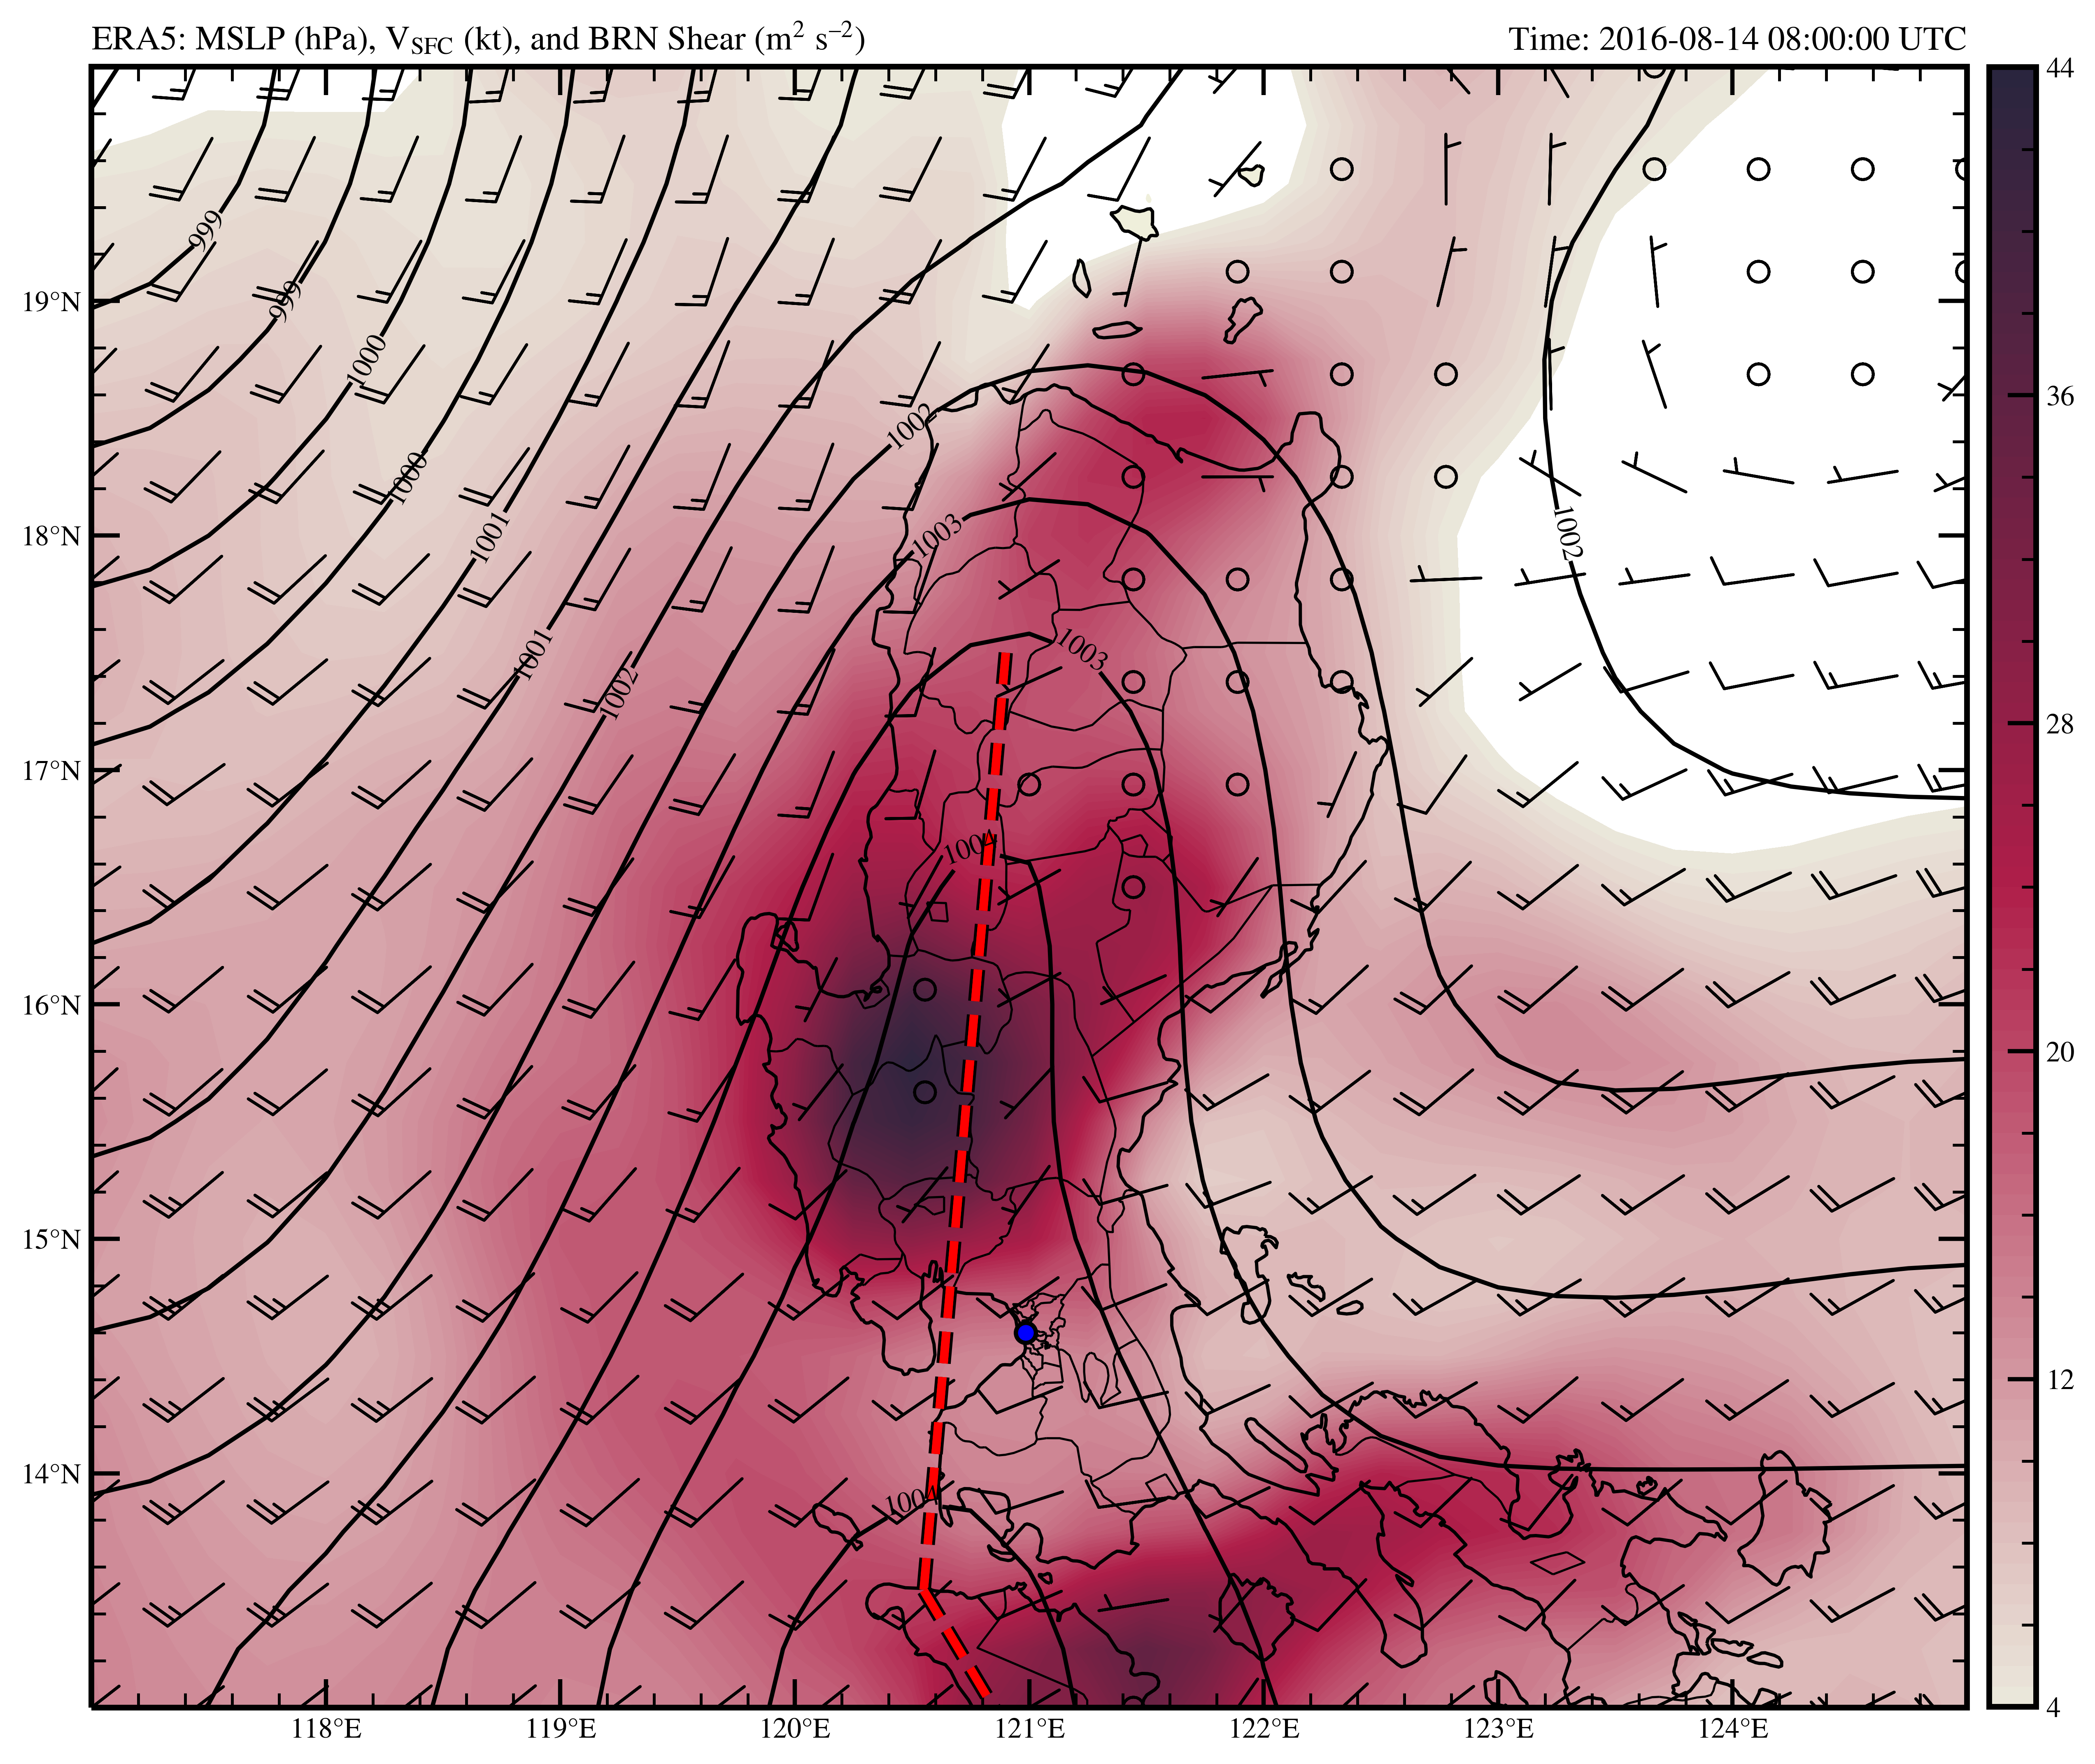

In [55]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.PlateCarree()

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=datacrs)
ax.set_extent([117, 125, 13, 20], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
states_provinces = cfeature.NaturalEarthFeature(category='cultural', 
                                                name='admin_1_states_provinces_lines', 
                                                scale='10m', facecolor='none', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='k')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.15)
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.add_feature(cfeature.LAND)

# Add BRN Shear contours
shr_range = np.arange(4, 44.5, 0.5)
shr = ax.contourf(lons, lats, brn_shear, shr_range, cmap='swift.red_r', transform=datacrs)
cbar = plt.colorbar(shr, orientation='vertical', pad=0.01, aspect=35, shrink=0.664, 
                    ticks=[4, 12, 20, 28, 36, 44])
cbar.ax.minorticks_on()
cbar.ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
cbar.ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Add Surface Winds using U and V-components
ax.barbs(lons, lats, uwnd_surf.to('kt').m, vwnd_surf.to('kt').m, pivot='middle',
         color='black', regrid_shape=17, transform=datacrs)

# Plot MSLP Contour
MSLP_range = np.arange(998, 1005, 0.5)
prs = ax.contour(lons, lats, mslph, MSLP_range, colors='k',
                 transform=datacrs, zorder=1)
ax.clabel(prs, fmt='%d')

# Create a line(s) that highlights the surface trough
outline=pe.withStroke(linewidth=5, foreground='k')

point1 = dict(lon=120.90, lat=17.50)
point2 = dict(lon=120.55, lat=13.50)
lon_p = [point1['lon'], point2['lon']]
lat_p = [point1['lat'], point2['lat']]
ax.plot(lon_p, lat_p, color='red', lw=3, ls='--',
        path_effects=[outline, pe.Normal()], transform=ccrs.Geodetic())

point3 = dict(lon=120.55, lat=13.50)
point4 = dict(lon=122.40, lat=10.40)
lon_p1 = [point3['lon'], point4['lon']]
lat_p1 = [point3['lat'], point4['lat']]
ax.plot(lon_p1, lat_p1, color='red', lw=3, ls='--', 
        path_effects=[outline, pe.Normal()], transform=ccrs.Geodetic())

# Make some nice titles for the plot (one right, one left)
ax.set_title(r'ERA5: MSLP (hPa), V$_{SFC}$ (kt), and BRN Shear (m$^{2}$ s$^{–2}$)', loc='left')
ax.set_title('Time: {} UTC'.format(vtime), loc='right')

# Add marker of Manila, NCR via its lats and lons
manila_lon, manila_lat = 120.9842, 14.5995
ax.plot(manila_lon, manila_lat, color='blue', markersize=7, 
        markeredgewidth=1.5, markeredgecolor='k', marker='o', transform=datacrs)

# Set X and Y-ticks for Latitude and Longitude Coordinates
ax.set_yticks(lats, 5, crs=ccrs.PlateCarree())
ax.set_xticks(lons, 5, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
long_formatter = cticker.LongitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_major_formatter(long_formatter)
ax.set_xticks(ax.get_xticks()[1:8]) #Hide end points of longitude tickmarks
ax.set_yticks(ax.get_yticks()[1:7]) #Hide end points of latitude tickmarks
ax.minorticks_on() 
ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["mathtext.default"] = 'regular'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.savefig('MLSP, Vsurf, BRN Shear.jpg', bbox_inches="tight")
plt.show()